In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# Define the file path (update it if the file is in a different location)
zip_file_path = './household_power_consumption.zip'  # Replace with your actual path
txt_file_name = 'household_power_consumption.txt'

# Extract the text file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    z.extract(txt_file_name)

# Load the dataset into a DataFrame
df = pd.read_csv(
    txt_file_name,
    sep=';',
    parse_dates=[[0, 1]],
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)

# Display the first few rows to confirm loading
df.head()


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [2]:
# Rename columns for convenience
df.columns = ['datetime', 'global_active_power', 'global_reactive_power',
              'voltage', 'global_intensity', 'sub_metering_1',
              'sub_metering_2', 'sub_metering_3']

# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' as the index for time-series analysis
df.set_index('datetime', inplace=True)

# Convert numerical columns to float (to handle missing values properly)
for col in ['global_active_power', 'global_reactive_power', 'voltage',
            'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the dataset summary
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    float64
 1   global_reactive_power  float64
 2   voltage                float64
 3   global_intensity       float64
 4   sub_metering_1         float64
 5   sub_metering_2         float64
 6   sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [3]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Display missing values and their percentage
pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage}).sort_values(by='Percentage', ascending=False)


,Missing Values,Percentage
global_active_power,25979,1.251844
global_reactive_power,25979,1.251844
voltage,25979,1.251844
global_intensity,25979,1.251844
sub_metering_1,25979,1.251844
sub_metering_2,25979,1.251844
sub_metering_3,25979,1.251844


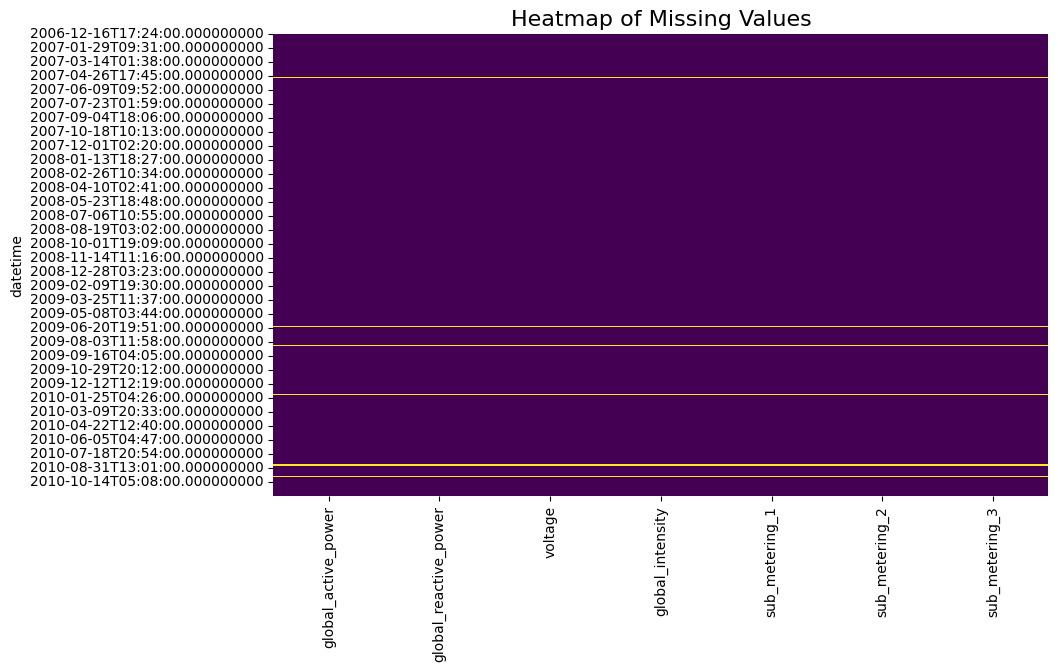

In [4]:
# Visualizing missing data using heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values', fontsize=16)
plt.show()


In [5]:
# Handling missing values by forward filling and backward filling
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Verify if there are still missing values
missing_after_fill = df.isnull().sum().sum()
print(f"Total missing values after filling: {missing_after_fill}")


Total missing values after filling: 0


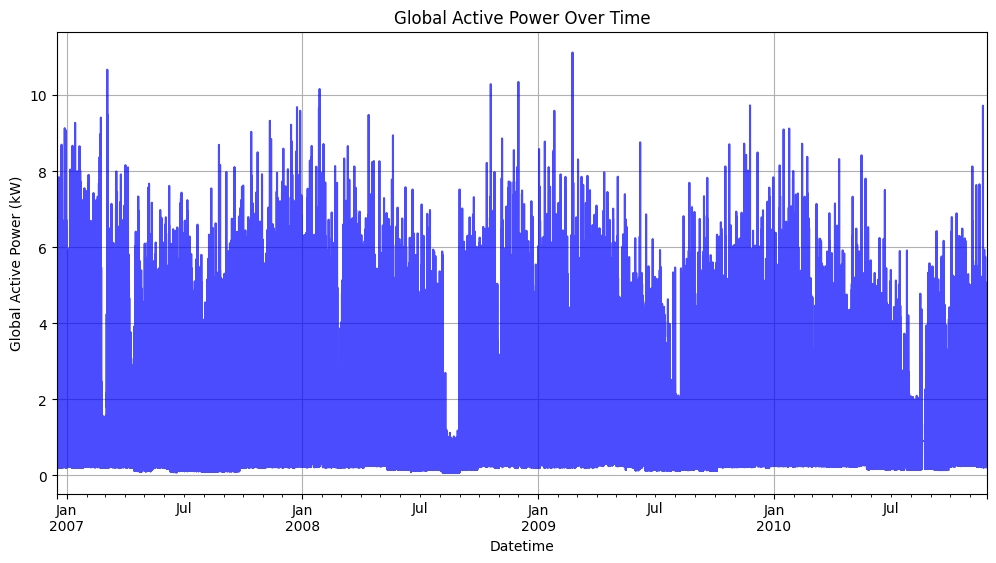

In [6]:
# Plotting the trend of global active power over time
plt.figure(figsize=(12, 6))
df['global_active_power'].plot(title='Global Active Power Over Time', color='blue', alpha=0.7)
plt.ylabel('Global Active Power (kW)')
plt.xlabel('Datetime')
plt.grid(True)
plt.show()


In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = df[['global_active_power', 'global_reactive_power', 'voltage',
               'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Display cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
centroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,0.708868,0.106078,-0.344661,0.690882,-0.147469,-0.121543,1.202451
1,-0.606407,-0.112539,0.277039,-0.598793,-0.174914,-0.151168,-0.706723
2,2.711150,0.678564,-1.095286,2.739675,3.205379,2.729563,0.568402


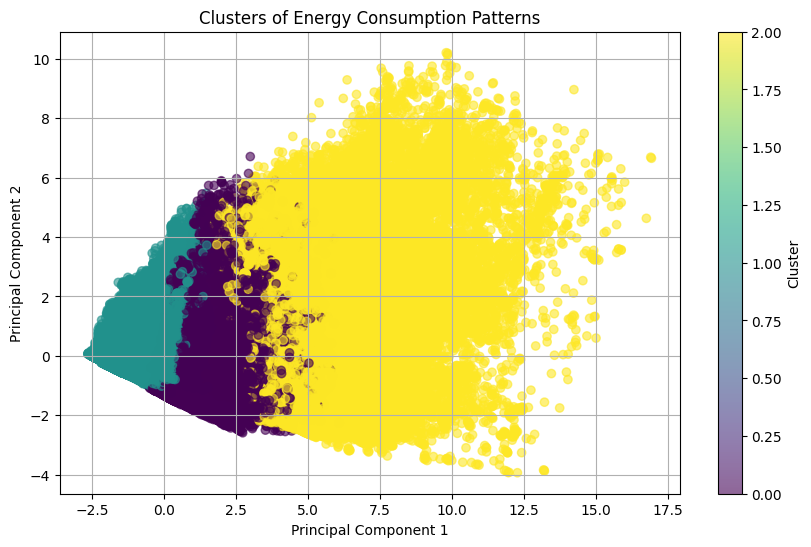

In [8]:
# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Create a scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6)
plt.title('Clusters of Energy Consumption Patterns')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


In [9]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% anomalies
df['anomaly'] = iso_forest.fit_predict(features_scaled)

# Anomaly labels: -1 indicates an anomaly, 1 indicates normal
anomalies = df[df['anomaly'] == -1]

# Count the anomalies
print(f"Number of anomalies detected: {len(anomalies)}")
anomalies.head()


Number of anomalies detected: 20752


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,cluster,anomaly
datetime,,,,,,,,,
2006-12-16 18:05:00,6.052,0.192,232.93,26.2,0.0,37.0,17.0,2,-1
2006-12-16 18:06:00,6.752,0.186,232.12,29.0,0.0,36.0,17.0,2,-1
2006-12-16 18:07:00,6.474,0.144,231.85,27.8,0.0,37.0,16.0,2,-1
2006-12-16 18:08:00,6.308,0.116,232.25,27.0,0.0,36.0,17.0,2,-1
2006-12-16 18:35:00,6.072,0.000,232.48,26.4,0.0,27.0,17.0,2,-1


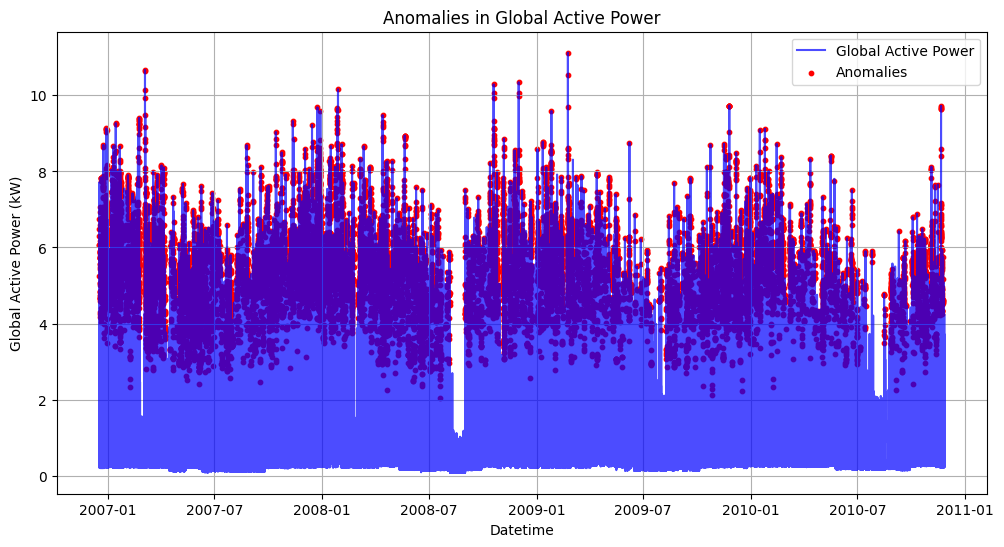

In [10]:
# Visualizing anomalies on Global Active Power
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['global_active_power'], label='Global Active Power', color='blue', alpha=0.7)
plt.scatter(anomalies.index, anomalies['global_active_power'], color='red', label='Anomalies', s=10)
plt.title('Anomalies in Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Create additional features based on datetime
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

# Drop anomaly and cluster columns to avoid leakage in modeling
df_model = df.drop(['anomaly', 'cluster'], axis=1)

# Check the final feature set
df_model.head()


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,year,month,day,hour,weekday
datetime,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,5
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,5
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,5
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,5
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,5


In [ ]:
from sklearn.model_selection import train_test_split

# Define target and features
X = df_model.drop(['global_active_power'], axis=1)
y = df_model['global_active_power']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (1660207, 11)
Testing set size: (415052, 11)


In [12]:
# Sample 1% of the dataset
df_sampled = df_model.sample(frac=0.01, random_state=42)

# Separate the features and target variable
X_sampled = df_sampled.drop(['global_active_power'], axis=1)
y_sampled = df_sampled['global_active_power']

# Combine for AutoViml
df_sampled_auto = X_sampled.copy()
df_sampled_auto['global_active_power'] = y_sampled

# Display the shape of the sampled dataset
print(f"Sampled dataset shape: {df_sampled_auto.shape}")
df_sampled_auto.head()


Sampled dataset shape: (20753, 12)


,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,year,month,day,hour,weekday,global_active_power
datetime,,,,,,,,,,,,
2010-07-07 18:10:00,0.106,242.00,1.2,0.0,0.0,1.0,2010,7,7,18,2,0.256
2007-05-14 06:50:00,0.352,237.22,2.4,0.0,2.0,0.0,2007,5,14,6,0,0.466
2007-09-26 18:10:00,0.194,238.66,3.2,0.0,1.0,0.0,2007,9,26,18,2,0.758
2007-06-19 07:30:00,0.046,240.64,5.4,1.0,0.0,18.0,2007,6,19,7,1,1.290
2010-05-10 04:43:00,0.202,242.23,1.8,0.0,2.0,1.0,2010,5,10,4,0,0.428


In [13]:
# Install AutoViml (if not already installed)
!pip install autoviml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of imbalanced-ensemble to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise, Random Forests will take too long for 10,000+ rows
Training Set Shape = (20753, 12)
    Training Set Memory Usage = 2.56 MB
Single_Label Target: ['global_active_power']

################ Regression VISUALIZATION Started #####################
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  6
    Number of Integer-Categorical Columns =  4
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of

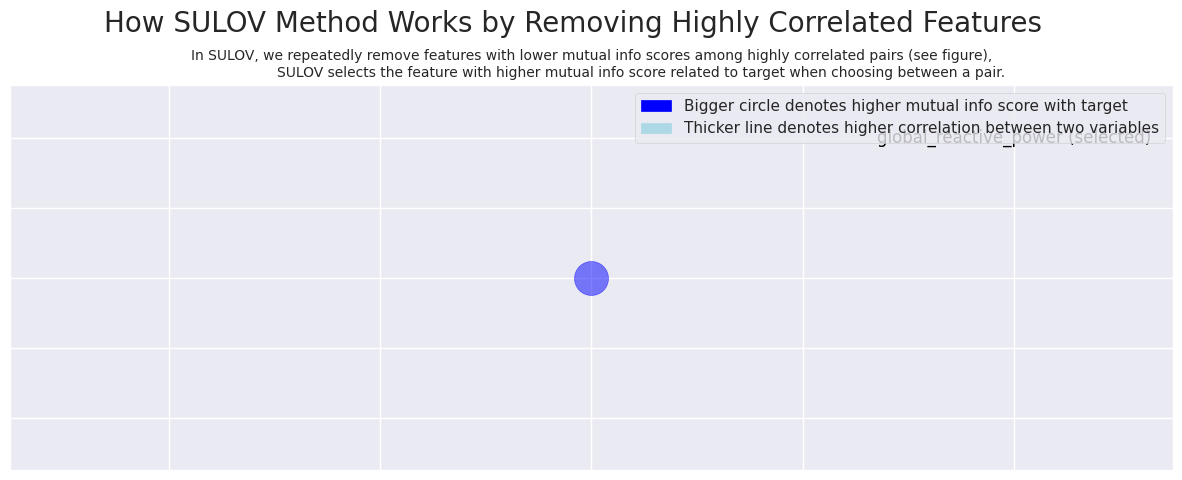

Splitting selected features into float and categorical (integer) variables:
    (6) float variables ...
    (6) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 12 
    Finding Important Features using Boosted Trees algorithm...
        using 12 variables...
        using 10 variables...
        using 8 variables...
        using 6 variables...
        using 4 variables...
        using 2 variables...
Found 12 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  16602 , CV rows =  4151
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in dat

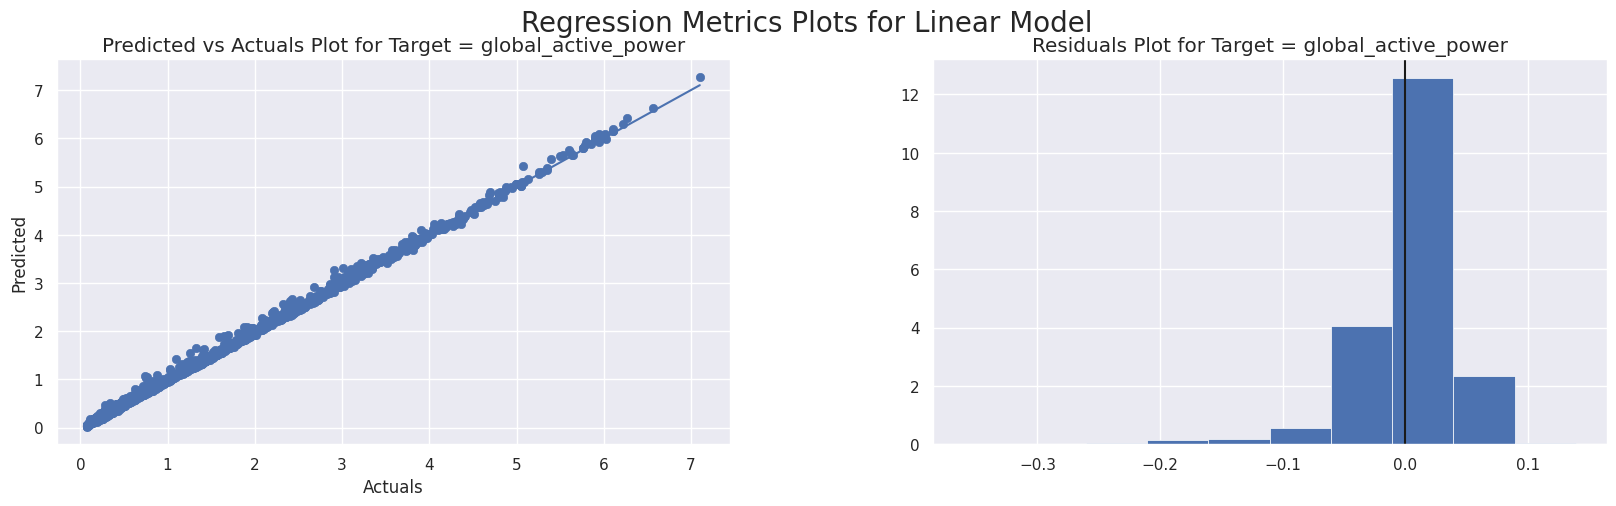

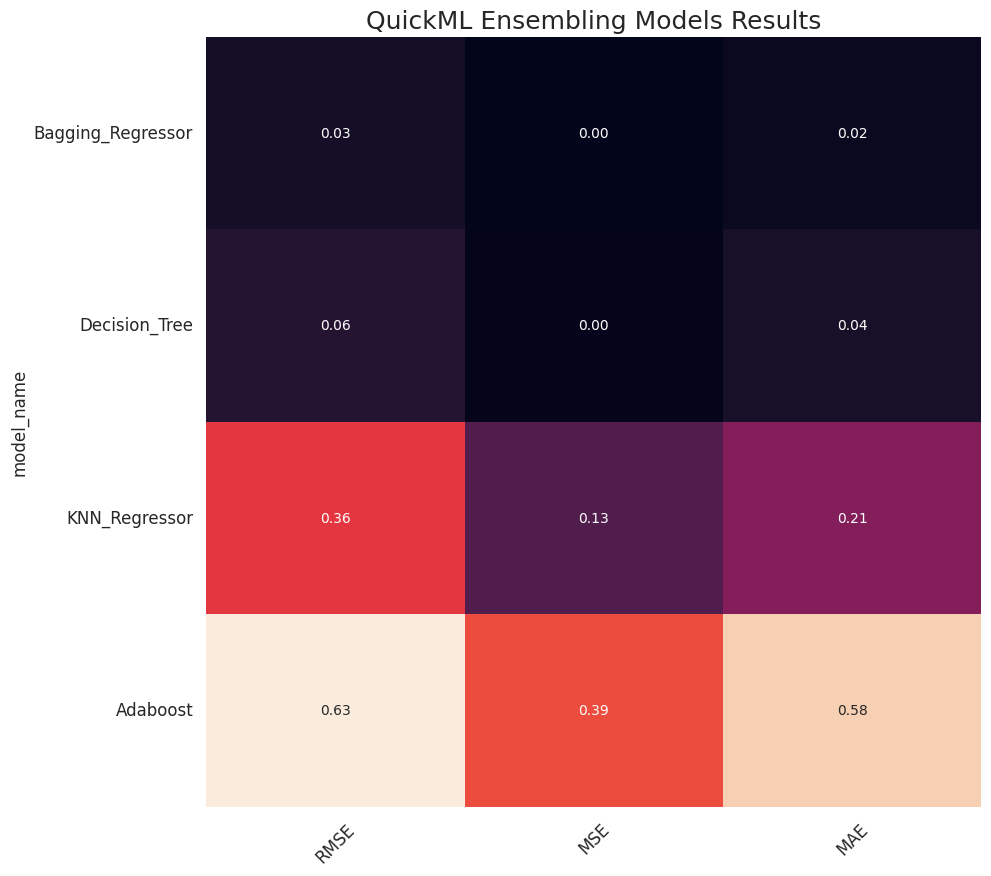

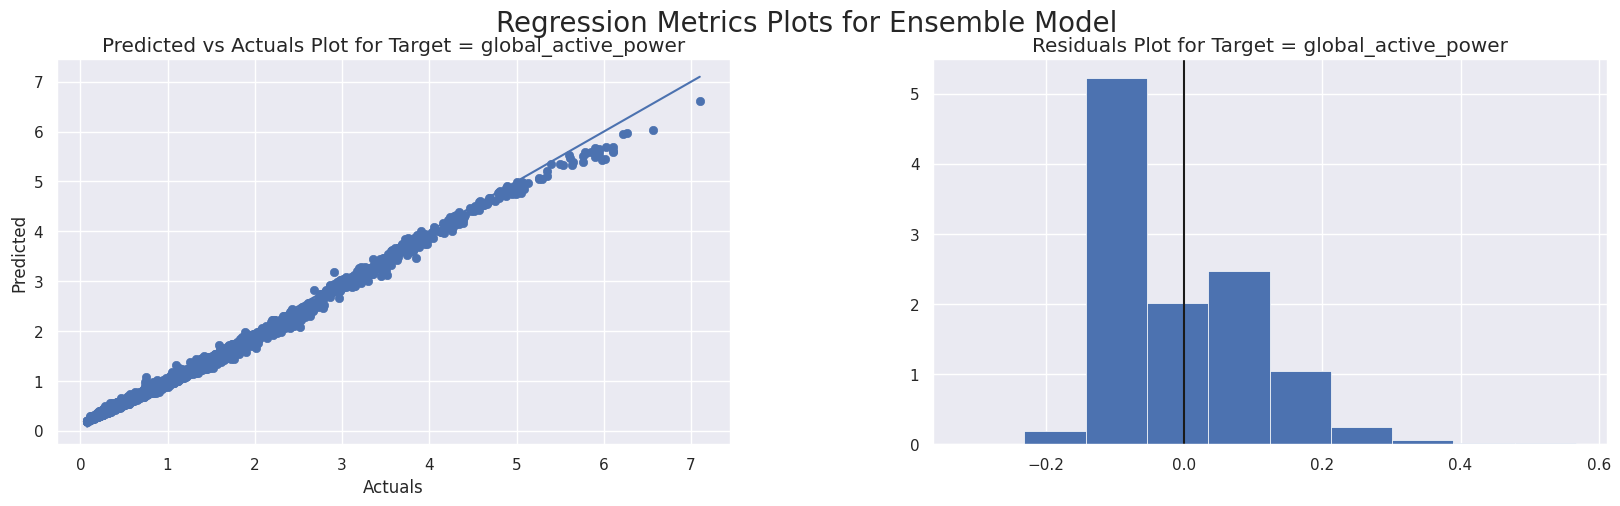

<Figure size 1500x500 with 0 Axes>

In [17]:
from autoviml.Auto_ViML import Auto_ViML

# Use AutoViml for training on the sampled dataset
target = 'global_active_power'  # Specify the target column
model, features, train, test = Auto_ViML(
    train=df_sampled_auto,
    target=target,
    test='',
    scoring_parameter='r2',  # Use R-squared as the evaluation metric
    hyper_param='RS',  # Random Search for hyperparameter tuning
    verbose=1
)


In [14]:
!pip install numpy==1.22.4

  Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which is incompatible.
arviz 0.20.0 requires numpy>=1.23.0, but you have numpy 1.22.4 which is incompatible.
arviz 0.20.0 requires scipy>=1.9.0, but you have scipy 1.7.3 which is incompatible.
astropy 6.1.6 requires num

In [16]:
import numpy
print(f"NumPy Version: {numpy.__version__}")

NumPy Version: 1.22.4


In [17]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which is incompatible.
arviz 0.20.0 requires scipy>=1.9.0, but you have scipy 1.7.3 which is incompatible.
autoviml 0.1.800 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.27.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 

In [2]:
# Downgrade scipy to a compatible version
!pip install scipy==1.7.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which is incompatible.
arviz 0.20.0 requires numpy>=1.23.0, but you have numpy 1.22.4 which is incompatible.
a

In [18]:
import joblib

# Save the best model
joblib.dump(model, 'autoviml_best_model.pkl')
print("Model saved as 'autoviml_best_model.pkl'")


Model saved as 'autoviml_best_model.pkl'
